# Using NP4VTT: Logistic regression (ANN-0)

In this notebook, we show how to use a logistic regression (ANN-0) model to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the logistic regression model, and Pandas to load the dataset:

In [13]:
import sys
sys.path.append('../src')

In [14]:
import pandas as pd

from py_np4vtt.data_format import Vars
from py_np4vtt.model_logistic import ModelLogistic, ConfigLogistic
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [15]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [16]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [17]:
columnarrays = {
    Vars.Id: 'RespID',
    Vars.ChosenAlt: 'Chosen',
    Vars.Cost1: 'CostL',
    Vars.Cost2: 'CostR',
    Vars.Time1: 'TimeL',
    Vars.Time2: 'TimeR',
}

And we create the required arrays:

In [18]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [19]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 10.2977
Minimum of BVTT: 0.6667
Maximum of BVTT: 113.5632


## Step 3: Configure a logistic regression model

The logistic regression model requires the following parameters from the user:

* `startScale`: The starting value of the scale parameter.
* `startIntercept`: The starting value of the intercept parameter
* `startParameter`: The starting value of the VTT parameter.
* `maxIterations:` Maximum iterations of the maximum likelihood estimation routine.

Additionally, the user can configure the following options:
* `seed`: Random seed for the array creation in the logistic regression model.

The function `ConfigLogistic` takes the configuration parameters of the logistic regression and creates an object that is used by the optimisation routine:

In [20]:
config = ConfigLogistic(startScale=1, startIntercept=0, startParameter=1, maxIterations=10000, seed=12345)

Now, we create the logistic regression model object that contains the configuration parameters and the data arrays.

In [21]:
logistic = ModelLogistic(config, model_arrays)

## Step 4: Estimate a logistic regression model

Once the logistic regression is initialised, the `run` method starts the optimisation process:

In [22]:
x, se, vtt, init_ll, ll, exitflag = logistic.run()

The estimated model returns the following information:

* `x:` The estimated parameters for the scale, intercept and the VTT parameter.
* `se:` The standard error of the estimated parameters.
* `vtt`: The VTT for each respondent.
* `init_ll:` Value of the likelihood function evaluated in the starting values.
* `ll:` Value of the likelihood function in the optimum.
* `exitflag:` Exit flag of the optimisation routine. If `exitflag=0`, the optimisation routine succeded.

The following lines present the estimated results:

In [23]:
import numpy as np

# Create dataframe
results = pd.DataFrame(np.c_[x,se],columns=['Estimate','Std.Err'],index=['Scale','Intercept','Parameter'])

print('Estimation results:\n')
print('Initial log-likelihood: ' + str(round(init_ll,2)))
print('Final log-likelihood: ' + str(round(ll,2)))
print('Estimates:')
print(results)

Estimation results:

Initial log-likelihood: -18194.05
Final log-likelihood: -2488.77
Estimates:
           Estimate   Std.Err
Scale      0.147390  0.004809
Intercept  2.253318  0.334880
Parameter  0.312939  0.009673


The VTT for each respondent can be computed from the estimated parameters and the model arrays:

## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

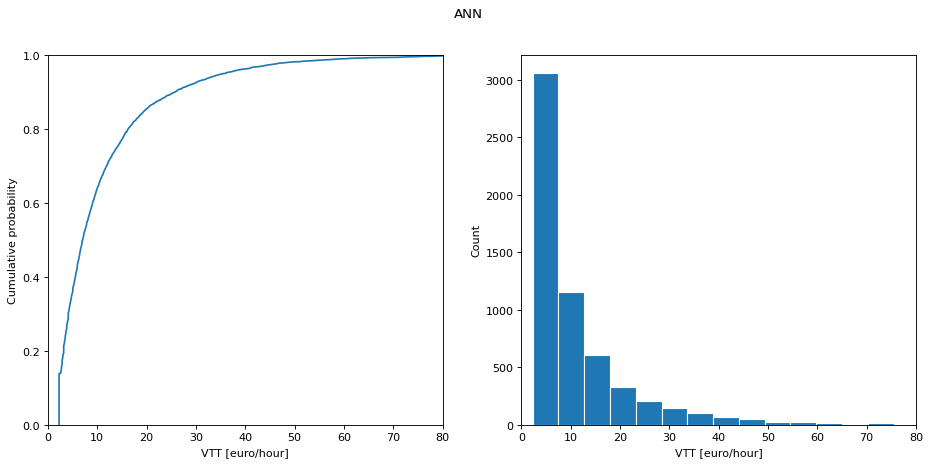

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(vtt)

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(ecdf.x,ecdf.y)
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Cumulative probability')

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(vtt,bins=20,edgecolor="white")
fig.suptitle('ANN')
plt.show()